In [1]:
#subset by longitude to look for local effects
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import dask.array as da
import dask.dataframe as dd
import xarray as xr
from xnemogcm import open_domain_cfg, get_metrics
import xgcm
import cartopy.crs as ccrs
import cmocean
import numpy as np
from scipy.stats import linregress
import datetime
import pandas as pd
import plots_spatial as pltspat
# Add SouthernDemons library to PATH
sys.path.append(os.path.abspath("../lib/"))
from teos_ten import teos_sigma0
import datesandtime

# Subdomain information (As inputted into TRACMASS, note non-pythonic indexing)
imindom = 1
imaxdom = 1440
jmindom = 1
jmaxdom = 400
kmindom = 1
kmaxdom = 75

# Location of the TRACMASS run
data_dir = os.path.abspath("/gws/nopw/j04/bas_pog/astyles/ORCA025_fwd/")

# Location of the OUTPUT directory created when running SouthernDemons executable
out_dir = os.path.abspath(data_dir + "/OUTPUT.ORCA025_fwd_extra/")

# Location of masks and grid information for the model
grid_path = os.path.abspath("/gws/nopw/j04/bas_pog/astyles/ORCA025_fwd/topo" )
grid_files = ['mask.nc','mesh_hgr.nc','mesh_zgr.nc']

cal_months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# Use dask to load the tabulated data lazily 
df_ini = dd.read_parquet(out_dir + f"/df_ini.combined.parquet")
df_out = dd.read_parquet(out_dir + f"/df_out.combined.parquet")
df_vent = dd.read_parquet(out_dir + f"/df_vent.parquet")
ds_domain = open_domain_cfg( datadir=grid_path, files = grid_files )

In [2]:
sum_z = np.array(ds_domain.e3t_1d['gdept_1d'])
z_index = np.array(ds_domain.e3t_1d['z_c'])
cell_z = np.append(np.array(da.diff(ds_domain.e3t_1d['gdept_1d'])),0)
df_sum_in = dd.from_dict({'bin_depth_i':sum_z,'binnedz_i':z_index, 'cell_h_i':cell_z},npartitions =3)
df_merge_in = df_vent.merge(df_sum_in,on = 'binnedz_i')
df_merge_in['depth_i'] = (df_merge_in['bin_depth_i'] - da.floor(df_merge_in['bin_depth_i']))* df_merge_in['cell_h_i'] + df_merge_in['bin_depth_i']

sum_z = np.array(ds_domain.e3t_1d['gdept_1d'])
z_index = np.array(ds_domain.e3t_1d['z_c'])
cell_z = np.append(np.array(da.diff(ds_domain.e3t_1d['gdept_1d'])),0)
df_sum_out = dd.from_dict({'bin_depth_o':sum_z,'binnedz_o':z_index, 'cell_h_o':cell_z},npartitions =3)
df_merge_out = df_vent.merge(df_sum_out,on = 'binnedz_o')
df_merge_out['depth_o'] = (df_merge_out['bin_depth_o'] - da.floor(df_merge_out['bin_depth_o']))* df_merge_out['cell_h_o'] + df_merge_out['bin_depth_o']

cols_to_use = df_merge_out.columns.intersection(df_merge_in.columns)
df_depths = df_merge_out.merge(df_merge_in, on = cols_to_use.to_list() ,how='left')

In [145]:
df_depths.head(10)

,ntraj_o,x_o,y_o,z_o,subvol_o,time_o,boxface_o,temp_o,sal_o,density_o,...,nd_bin_ini,sf_zint,bathy_depth_i,bathy_depth_o,bin_depth_o,cell_h_o,depth_o,bin_depth_i,cell_h_i,depth_i
0,853,1150.47,109.13,11.18,3.019280e+08,4.363200e+05,0,-1.78,33.99,27.23,...,78,6.079423,2629.801270,1949.970459,19.429803,3.327813,20.860106,19.429803,3.327813,20.860106
1,10418,1143.07,167.60,21.88,7.669823e+08,1.339632e+07,0,-1.09,34.12,27.32,...,87,47.981816,5320.347656,5184.746094,86.929425,10.111887,96.327670,86.929425,10.111887,96.327670
2,669214,1156.00,207.76,21.11,9.963935e+08,5.802122e+08,1,0.20,34.07,27.22,...,102,19.637180,2854.579346,4452.546875,77.611162,9.318264,83.306128,947.447897,98.406405,991.523839
3,632430,1213.32,189.92,24.00,9.545360e+08,6.194080e+08,6,-1.61,34.13,27.34,...,105,28.164009,3342.843750,5121.208984,108.030281,11.969720,108.392735,856.678942,90.768955,918.305830
4,21060,961.92,193.73,19.84,7.158713e+08,1.454242e+08,0,-1.68,34.00,27.24,...,93,23.522944,3703.224365,865.108826,69.021684,8.589478,69.207937,163.164456,17.385466,166.023608
5,623622,1188.23,250.44,18.59,7.958651e+08,2.164320e+06,0,2.00,33.81,26.90,...,74,19.330925,3300.907959,3113.864014,61.112840,7.908844,62.005276,69.021684,8.589478,69.207937
6,346,1162.49,389.58,11.52,7.274983e+08,3.892320e+06,0,23.11,35.87,24.43,...,14,-122.778606,2848.244629,4297.509766,22.757616,3.800685,25.637077,13.991038,2.534284,16.502609
7,721201,939.65,314.00,16.77,9.970858e+08,3.036541e+08,4,14.03,35.47,26.41,...,73,-168.995150,5089.613770,5596.249236,47.211894,6.638743,48.618604,773.368259,83.310683,804.048166
8,35856,1334.14,187.39,22.57,9.672347e+08,1.093003e+08,0,-0.24,33.90,27.10,...,89,26.204719,2067.115967,5190.488497,97.041313,10.988968,97.495295,244.890622,26.465765,268.461607
9,96420,1193.96,217.67,22.63,9.894534e+08,5.486443e+08,0,0.18,34.03,27.18,...,106,24.876176,4478.903320,5468.986816,97.041313,10.988968,97.495295,697.258648,76.109611,716.944227


In [25]:
df_vent.dtypes

ntraj_o            int64
x_o              float64
y_o              float64
z_o              float64
subvol_o         float64
time_o           float64
boxface_o          int64
temp_o           float64
sal_o            float64
density_o        float64
density10_o      float64
ntrajc             int64
ntraj_i            int64
x_i              float64
y_i              float64
z_i              float64
subvol_i         float64
time_i           float64
boxface_i          int64
temp_i           float64
sal_i            float64
density_i        float64
density10_i      float64
year_i             int64
month_i            int64
day_i              int64
dayofyear_i        int64
year_o             int64
month_o            int64
day_o              int64
dayofyear_o        int64
binnedx_i          int64
binnedy_i          int64
binnedz_i          int64
binnedx_o          int64
binnedy_o          int64
binnedz_o          int64
nd_bin_ini         int64
sf_zint          float64
bathy_depth_i    float64


In [4]:
def plot(ds_domain, vol_xy, y,vmax=1e3,log=True, cmp =cmocean.cm.thermal ): 
    #print((vol_xy.head(5)))
    da_vol_xy = vol_xy.to_xarray()[y]
    #print(da_vol_xy.head(4))
    # Define coordinates x_c and y_c which are the Pythonic indices rather than the TRACMASS indices. This ensures agreement with the coordinates for ds_domain
  
    da_vol_xy = da_vol_xy.assign_coords( {'x_c':da_vol_xy.binnedx_i-1 , 'y_c':da_vol_xy.binnedy_i - 1} ) 
    da_vol_xy = da_vol_xy.swap_dims({'binnedx_i':'x_c', 'binnedy_i':'y_c'})
    
    # Reorder axes to agree with ds_subdomain
    da_vol_xy = da_vol_xy.transpose("y_c","x_c",...)
    
    
    # Align the coordinates of the grid file with the subdomain in da_vol_xy
    ds_domain_allign, da_vol_xy = xr.align( ds_domain, da_vol_xy )

    fig, ax = plt.subplots(1,1,dpi=200,subplot_kw={'projection':ccrs.SouthPolarStereo()})
    lat = ds_domain_allign.gphit
    lon = ds_domain_allign.glamt
    
    
    
    #vmax = vnorm.max().compute()

    
    vmin=vmax*1e-3    
    if log == True:
        lognorm = matplotlib.colors.LogNorm(vmax = vmax, vmin = vmax /1e3 )
        cax = ax.pcolormesh( lon, lat, da_vol_xy, transform=ccrs.PlateCarree(), cmap=cmp, norm=lognorm )
    else:
        cax = ax.pcolormesh( lon, lat,  da_vol_xy, transform=ccrs.PlateCarree(), cmap=cmp)
    ax.coastlines()
    fig.colorbar(cax)
    return fig ,ax

In [3]:
def plot_o(ds_domain, vol_xy, y,vmax=1e3,log=True, cmp =cmocean.cm.thermal ): 
    #print((vol_xy.head(5)))
    da_vol_xy = vol_xy.to_xarray()[y]
    #print(da_vol_xy.head(4))
    # Define coordinates x_c and y_c which are the Pythonic indices rather than the TRACMASS indices. This ensures agreement with the coordinates for ds_domain
  
    da_vol_xy = da_vol_xy.assign_coords( {'x_c':da_vol_xy.binnedx_o-1 , 'y_c':da_vol_xy.binnedy_o - 1} ) 
    da_vol_xy = da_vol_xy.swap_dims({'binnedx_o':'x_c', 'binnedy_o':'y_c'})
    
    # Reorder axes to agree with ds_subdomain
    da_vol_xy = da_vol_xy.transpose("y_c","x_c",...)
    
    
    # Align the coordinates of the grid file with the subdomain in da_vol_xy
    ds_domain_allign, da_vol_xy = xr.align( ds_domain, da_vol_xy )

    fig, ax = plt.subplots(1,1,dpi=200,subplot_kw={'projection':ccrs.SouthPolarStereo()})
    lat = ds_domain_allign.gphit
    lon = ds_domain_allign.glamt
    
    
    
    #vmax = vnorm.max().compute()

    
    vmin=vmax*1e-3    
    if log == True:
        lognorm = matplotlib.colors.LogNorm(vmax = vmax, vmin = vmax /1e3 )
        cax = ax.pcolormesh( lon, lat, da_vol_xy, transform=ccrs.PlateCarree(), cmap=cmp, norm=lognorm )
    else:
        cax = ax.pcolormesh( lon, lat,  da_vol_xy, transform=ccrs.PlateCarree(), cmap=cmp)
    ax.coastlines()
    fig.colorbar(cax)
    return fig ,ax

[]

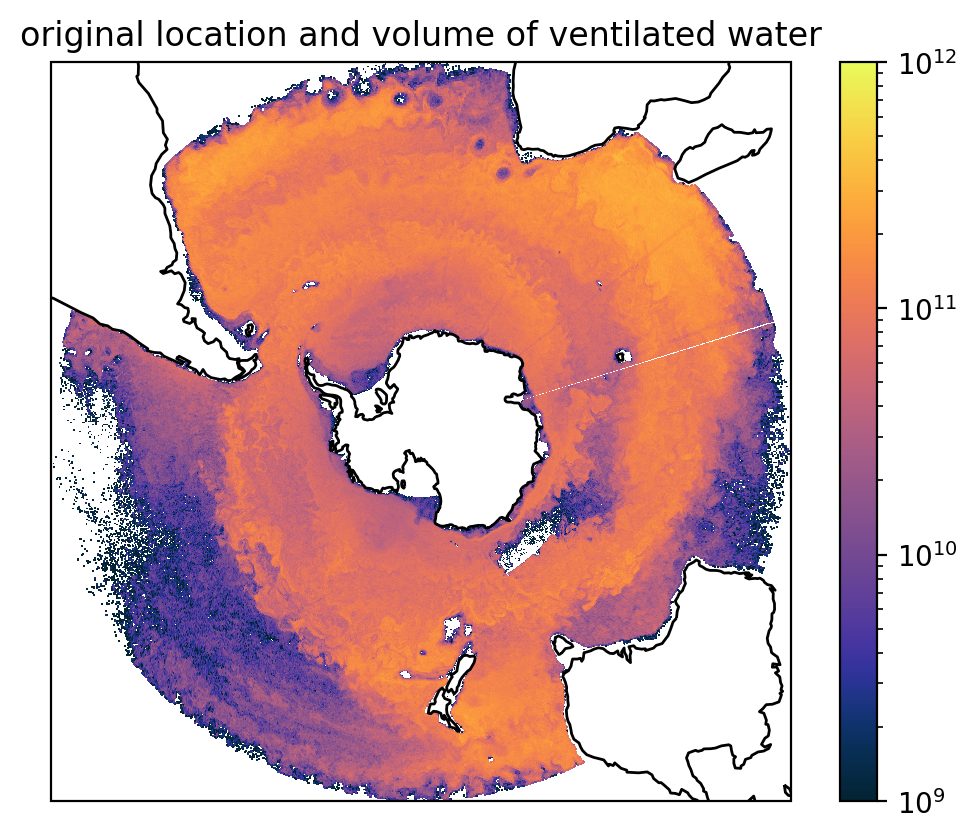

In [66]:
df_late = df_vent[df_vent['year_o']>1983]
df = df_late
df = df[['binnedx_i','binnedy_i','subvol_i','bathy_depth_i']]
# Group together data which ventilated in the same horizontal grid cell (same combination of binnedx and binnedy)
df_group = df.groupby( ['binnedx_i','binnedy_i'])
# Calculate total volume in each grid cell
vol_xy = df_group.sum("subvol_i").compute()

plot(ds_domain, vol_xy,'subvol_i',vmax=1e12)
plt.title('original location and volume of ventilated water')
plt.plot()


Text(0.5, 1.0, 'original location and volume of ventilated water NORMALISED')

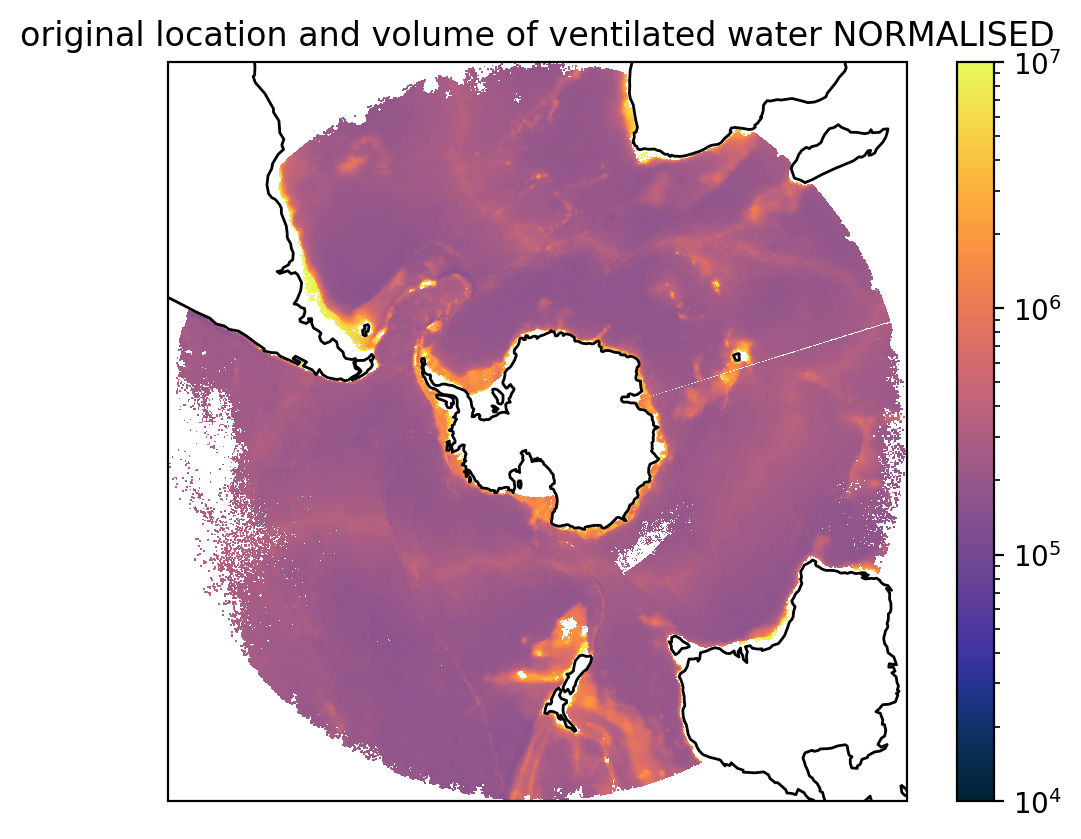

In [67]:

vol_xy['subvol_norm'] = vol_xy['subvol_i']/vol_xy['bathy_depth_i']
plot(ds_domain, vol_xy,'subvol_norm',vmax=1e7)
plt.title('original location and volume of ventilated water NORMALISED')



In [ ]:
############ now look at subsetting by initial depth

In [24]:
#bathymetry data

df = df_merge_in[['binnedx_i','binnedy_i','subvol_i','bathy_depth_i']]
# Group together data which ventilated in the same horizontal grid cell (same combination of binnedx and binnedy)
df_group = df.groupby( ['binnedx_i','binnedy_i'])
# Calculate total volume in each grid cell
vol_xy = df_group.max("bathy_depth_i").compute()

[]

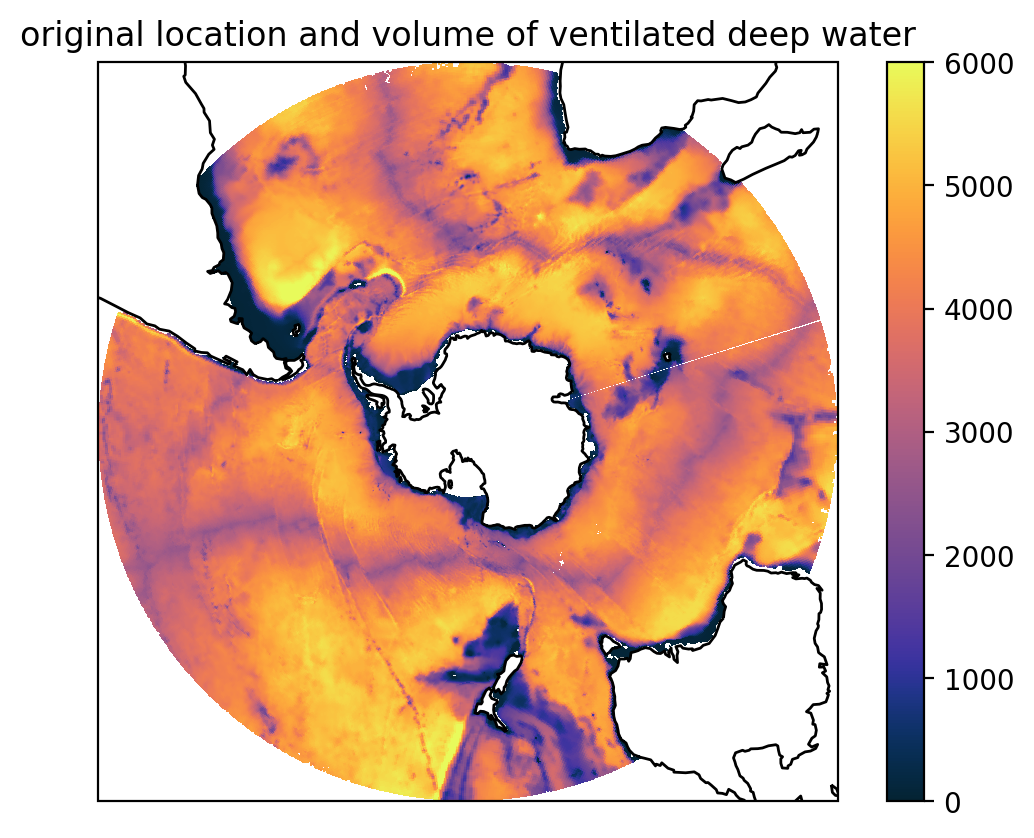

In [25]:
plot(ds_domain, vol_xy,'bathy_depth_i',vmax=1e3,log=False)
plt.title('original location and volume of ventilated deep water')
plt.plot()

In [26]:
###deepest waters:
df_deep = df_merge_in[df_merge_in['depth_i']>2100]
df = df_deep
df = df[['binnedx_i','binnedy_i','subvol_i','bathy_depth_i']]
# Group together data which ventilated in the same horizontal grid cell (same combination of binnedx and binnedy)
df_group = df.groupby( ['binnedx_i','binnedy_i'])
# Calculate total volume in each grid cell
vol_xy = df_group.sum("subvol_i").compute()




[]

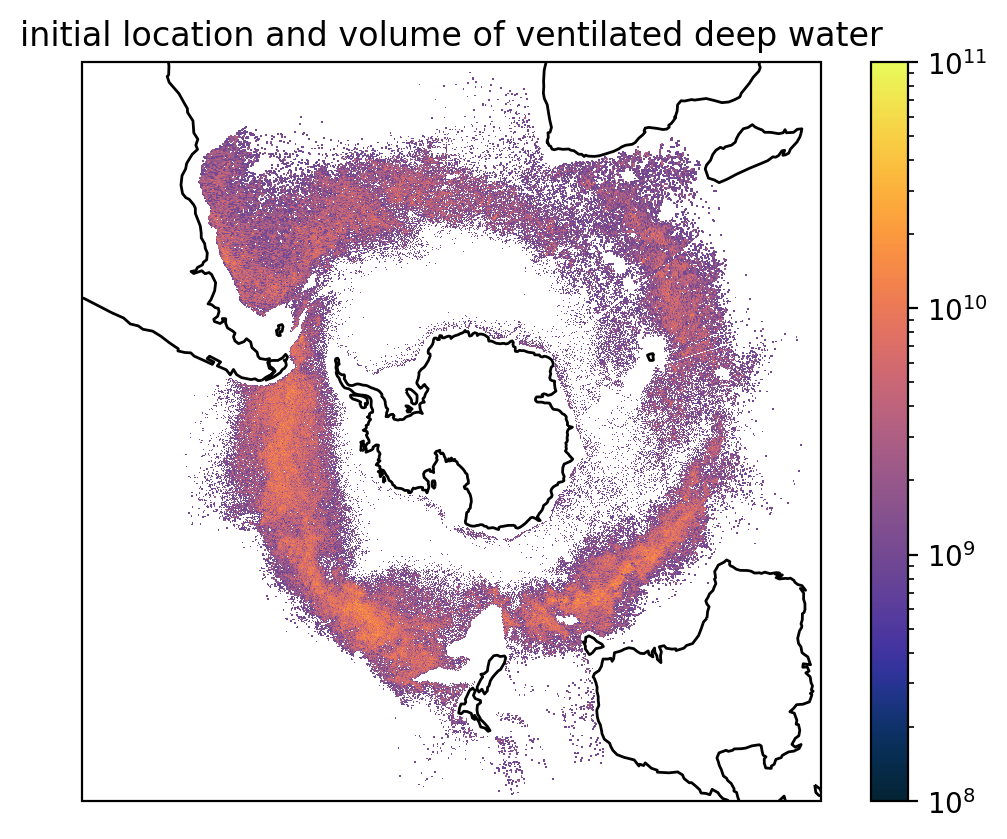

In [27]:
plot(ds_domain, vol_xy,'subvol_i',vmax=1e11)
plt.title('initial location and volume of ventilated deep water')
plt.savefig('../fig/Deep_water/seeding.png')


In [28]:
df_deep = df_merge_in[df_merge_in['depth_i']>2100]
df = df_deep
df = df[['binnedx_o','binnedy_o','subvol_o']]
# Group together data which ventilated in the same horizontal grid cell (same combination of binnedx and binnedy)
df_group = df.groupby( ['binnedx_o','binnedy_o'])
# Calculate total volume in each grid cell
vol_xy = df_group.sum("subvol_o").compute()


[]

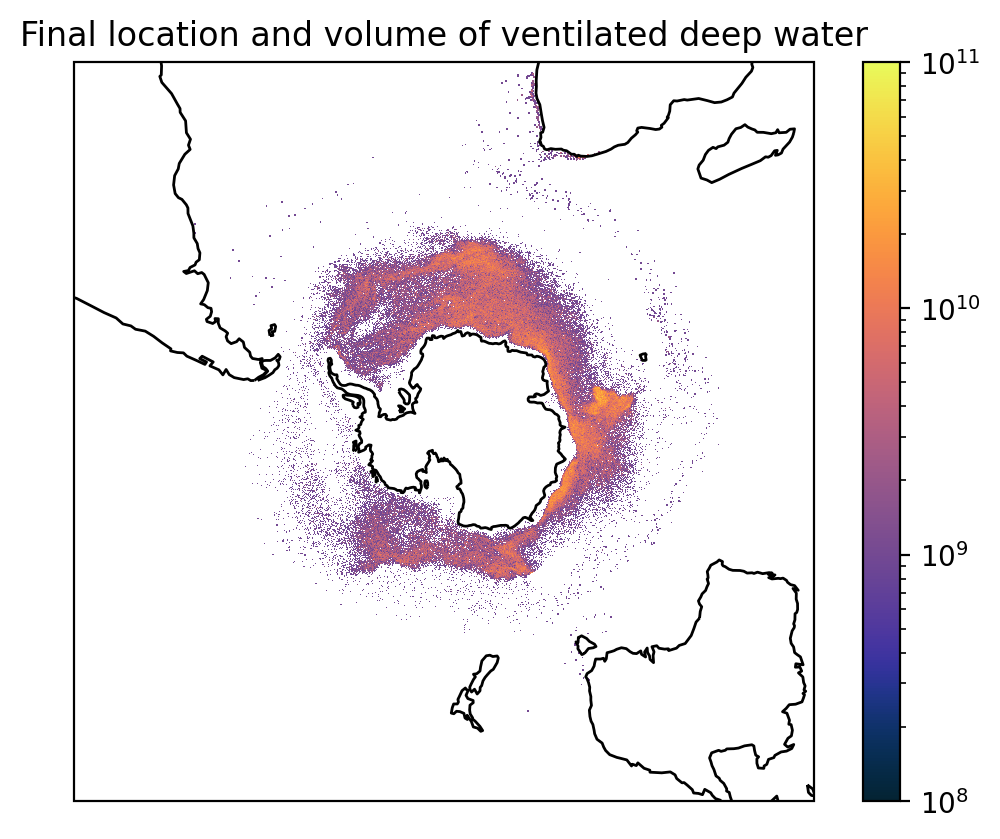

In [29]:
plot_o(ds_domain, vol_xy,'subvol_o',vmax=1e11)
plt.title('Final location and volume of ventilated deep water')
plt.savefig('../fig/Deep_water/ventialtion.png')



In [ ]:
######look at average depth change

